In [46]:
# Load, explore and plot data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

# Train test split
from sklearn.model_selection import train_test_split

# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

In [47]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Loading Dataset

In [49]:
df = pd.read_csv('https://raw.githubusercontent.com/kenneth-lee-ch/SMS-Spam-Classification/master/spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [50]:
# renaming colums
df = df[['v1', 'v2']]
df.rename(columns={'v1': 'label', 'v2': 'text'}, inplace=True)
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [51]:
df.describe()


,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [52]:
df.groupby('label').describe().T

label                           ham  \
text count                     4825   
     unique                    4516   
     top     Sorry, I'll call later   
     freq                        30   

label                                                     spam  
text count                                                 747  
     unique                                                653  
     top     Please call our customer service representativ...  
     freq                                                    4

## Visualizations

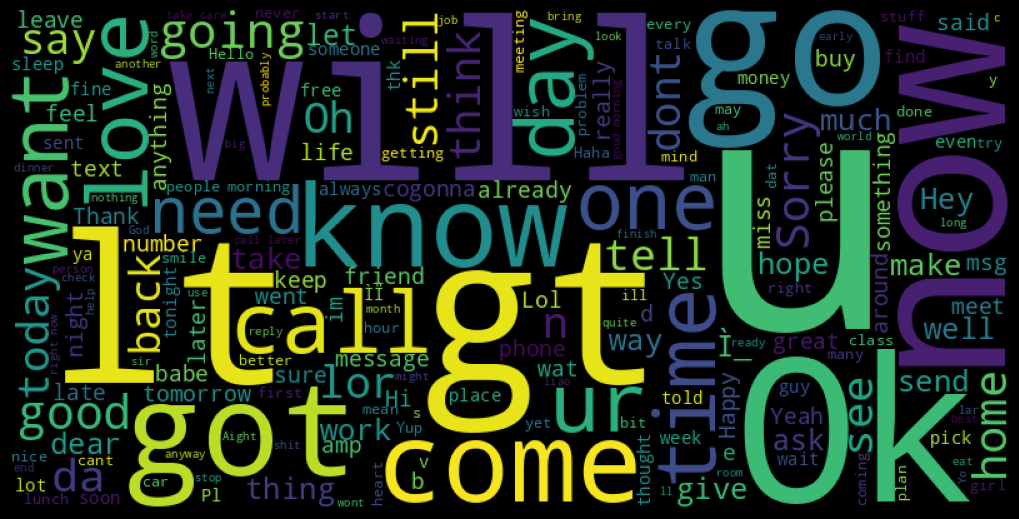

In [53]:
ham_cloud = WordCloud(width=800, height=400, background_color='black', stopwords=STOPWORDS).generate(' '.join(df[df['label'] == 'ham']['text']))
plt.figure(figsize=(10, 8), facecolor='k')
plt.imshow(ham_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

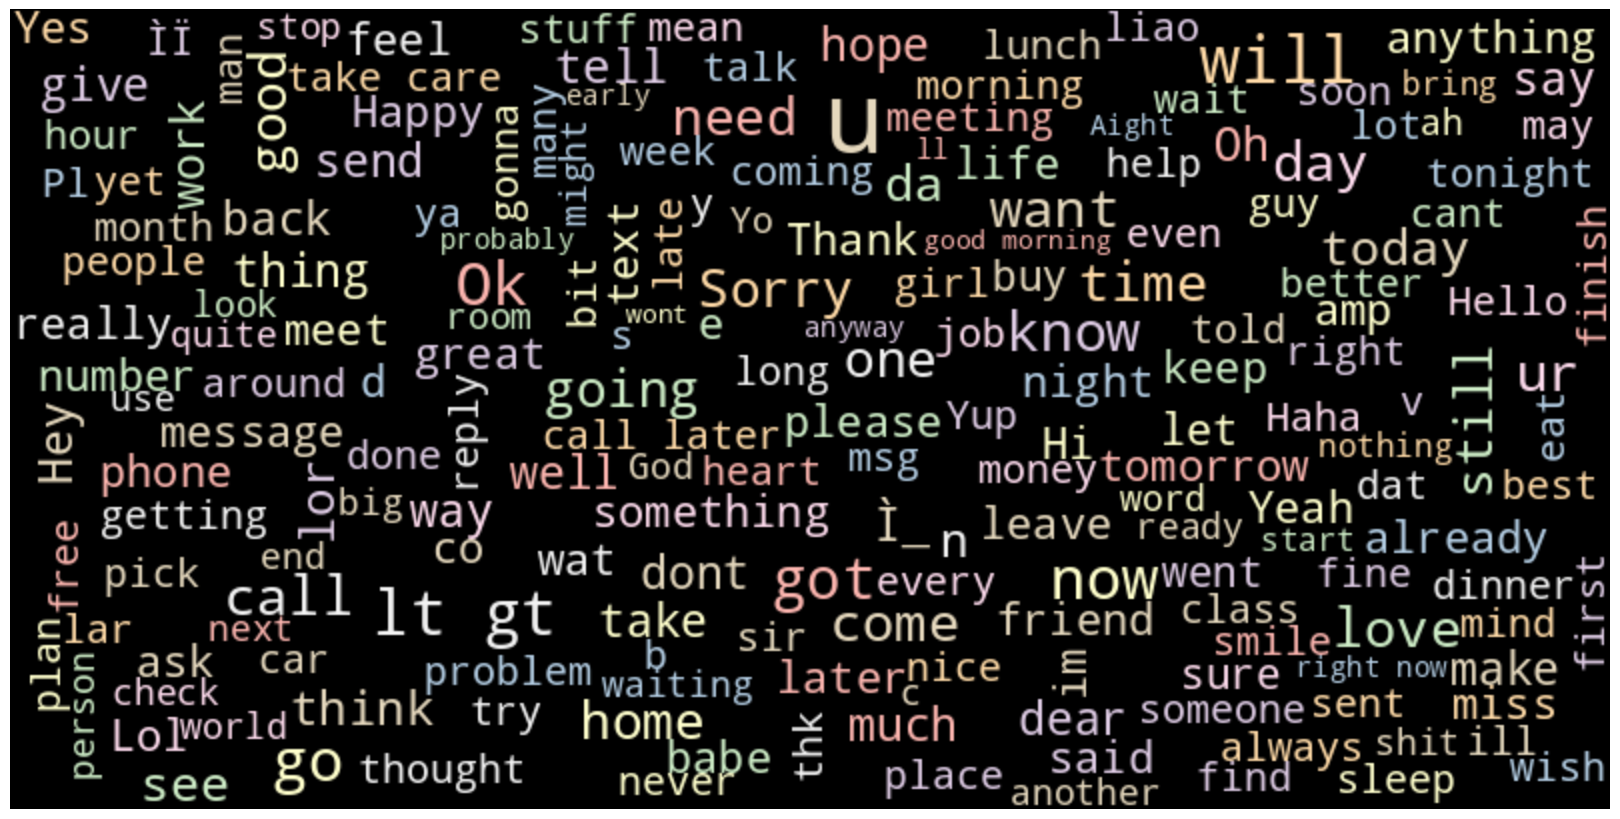

In [54]:
ham_text = ' '.join(df[df['label'] == 'ham']['text'])
ham_cloud = WordCloud(width=800, height=400, background_color='black', stopwords=STOPWORDS, max_font_size=50, colormap='Pastel1').generate(ham_text)
plt.figure(figsize=(16, 10))
plt.imshow(ham_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

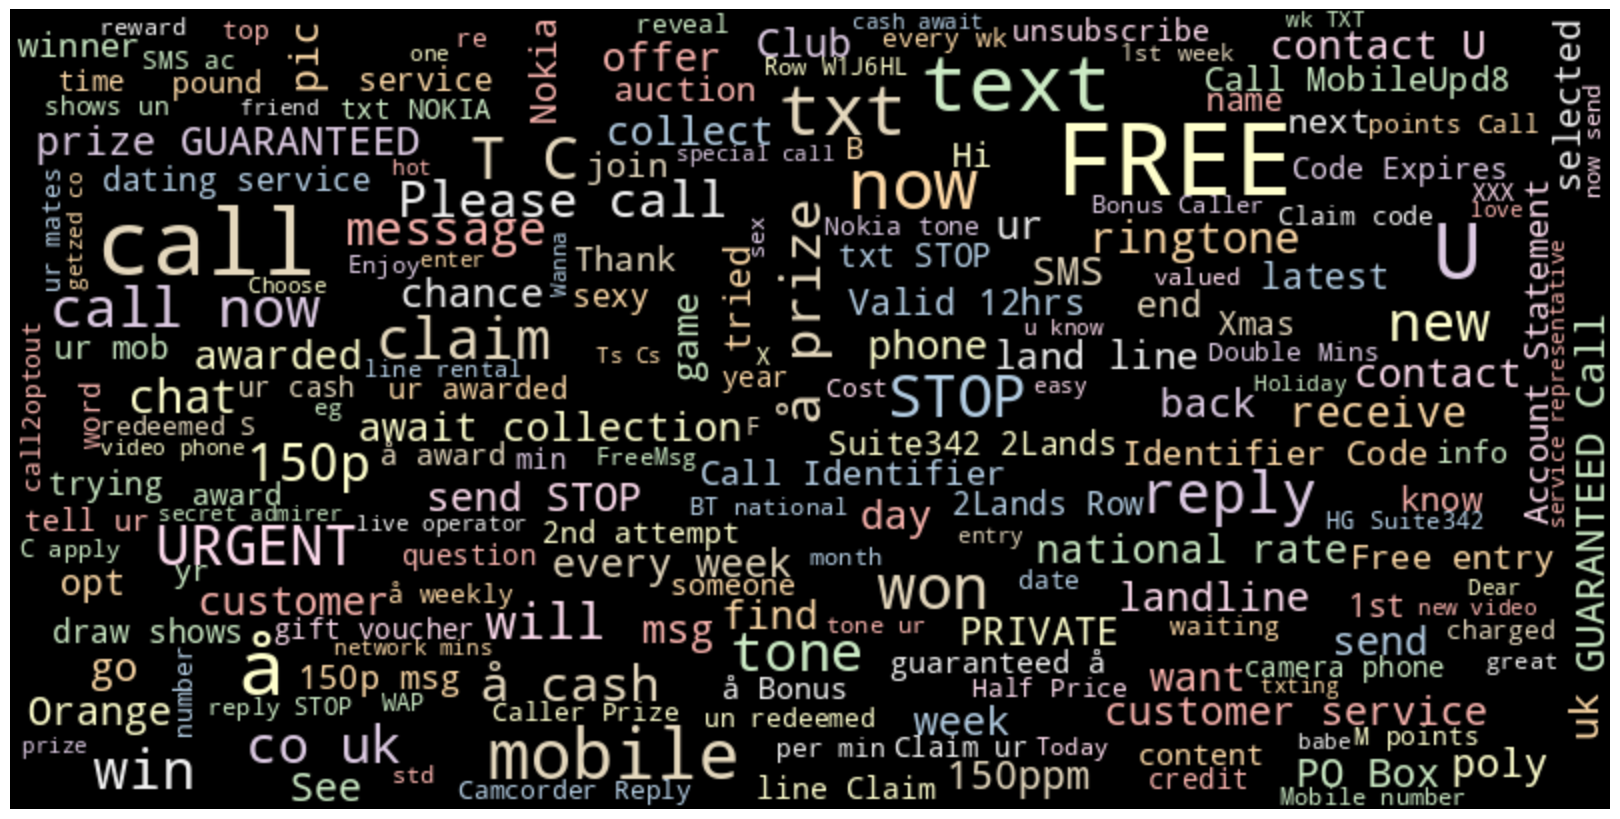

In [55]:
spam = ' '.join(df[df['label'] == 'spam']['text'])
spam_cloud = WordCloud(width=800, height=400, background_color='black', stopwords=STOPWORDS, max_font_size=50, colormap='Pastel1').generate(spam)
plt.figure(figsize=(16, 10))
plt.imshow(spam_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Data Imbalance

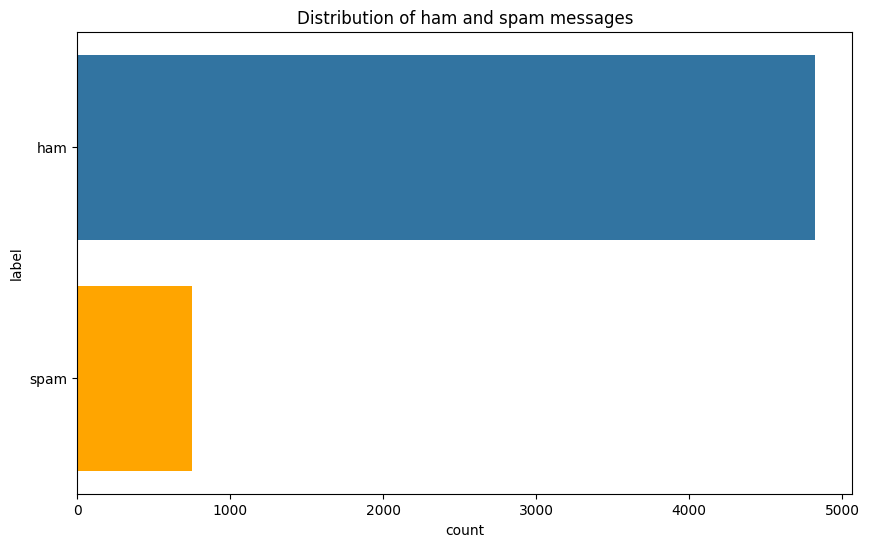

In [56]:
plt.figure(figsize=(10, 6))
sns.countplot(df.label)
plt.gca().patches[1].set_facecolor('orange')
plt.title('Distribution of ham and spam messages')
plt.show()

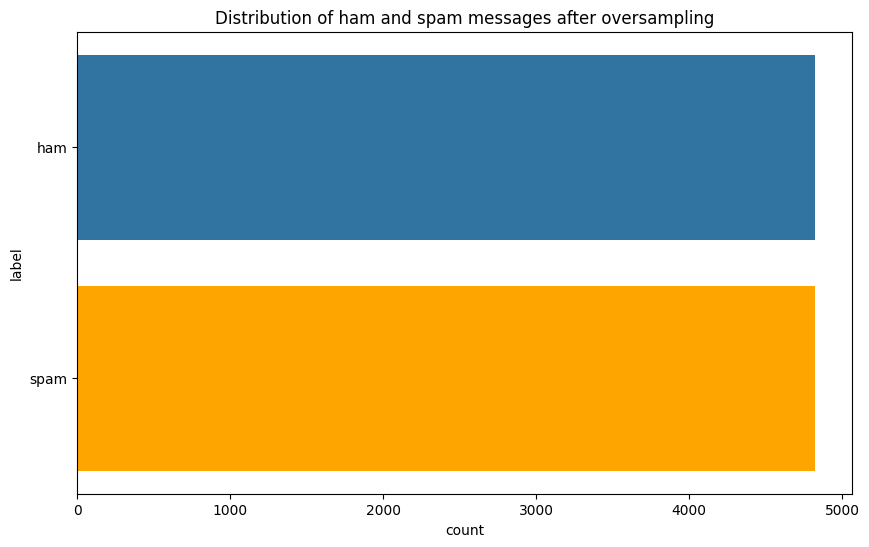

In [57]:
# oversample spam
spam = df[df['label'] == 'spam']
ham = df[df['label'] == 'ham']
spam_upsampled = spam.sample(n=len(ham), replace=True, random_state=42)
df = pd.concat([ham, spam_upsampled])
plt.figure(figsize=(10, 6))
sns.countplot(df.label)
plt.gca().patches[1].set_facecolor('orange')
plt.title('Distribution of ham and spam messages after oversampling')
plt.show()

In [58]:
# save it as first set
df.to_csv('spam_oversampled.csv', index=False)


## Text Processing

In [59]:
msg_df = pd.read_csv('spam_oversampled.csv')
msg_df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I don't think he goes to usf, he lives aro..."
4,ham,Even my brother is not like to speak with me. ...


In [60]:
msg_df['text_length'] = msg_df['text'].apply(len)
msg_df.head()

,label,text,text_length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,ham,U dun say so early hor... U c already then say...,49
3,ham,"Nah I don't think he goes to usf, he lives aro...",61
4,ham,Even my brother is not like to speak with me. ...,77


In [61]:
msg_df['text_type'] = msg_df['label'].map({'ham': 0, 'spam': 1})
msg_labels = msg_df['text_type'].values
msg_df.head()

,label,text,text_length,text_type
0,ham,"Go until jurong point, crazy.. Available only ...",111,0
1,ham,Ok lar... Joking wif u oni...,29,0
2,ham,U dun say so early hor... U c already then say...,49,0
3,ham,"Nah I don't think he goes to usf, he lives aro...",61,0
4,ham,Even my brother is not like to speak with me. ...,77,0


## Train Test Split

In [62]:
X_train, X_test, y_train, y_test = train_test_split(msg_df['text'], msg_labels, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7720,) (1930,) (7720,) (1930,)


## Tokenization


In [63]:
max_len = 100
trunc_type = 'post'
padding_type = 'post'
oov_token = '<OOV>'
vocab_size = 500

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

total_words = len(word_index)
total_words

8151

In [64]:
# sequence and padding

# for train data
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

# for test data
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

print('Shape of training padded:', training_padded.shape)
print('Shape of testing padded:', testing_padded.shape)

Shape of training padded: (7720, 100)
Shape of testing padded: (1930, 100)


## Dense Model Architecture and Training

In [65]:
# define parameters
vocab_size = 500
embedding_dim = 16
drop_value = 0.2
n_dense = 24

In [66]:
# define model architecture

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

model.build(input_shape=(None, max_len))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,433 (32.94 KB)

 Trainable params: 8,433 (32.94 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test), callbacks=[early_stop], verbose=2)

Epoch 1/30
242/242 - 3s - 11ms/step - accuracy: 0.7018 - loss: 0.5941 - val_accuracy: 0.8720 - val_loss: 0.4077
Epoch 2/30
242/242 - 1s - 6ms/step - accuracy: 0.9092 - loss: 0.2803 - val_accuracy: 0.9399 - val_loss: 0.1939
Epoch 3/30
242/242 - 1s - 6ms/step - accuracy: 0.9503 - loss: 0.1574 - val_accuracy: 0.9554 - val_loss: 0.1262
Epoch 4/30
242/242 - 2s - 7ms/step - accuracy: 0.9614 - loss: 0.1188 - val_accuracy: 0.9580 - val_loss: 0.1079
Epoch 5/30
242/242 - 2s - 6ms/step - accuracy: 0.9663 - loss: 0.1055 - val_accuracy: 0.9585 - val_loss: 0.0982
Epoch 6/30
242/242 - 2s - 6ms/step - accuracy: 0.9705 - loss: 0.0912 - val_accuracy: 0.9554 - val_loss: 0.1238
Epoch 7/30
242/242 - 1s - 5ms/step - accuracy: 0.9707 - loss: 0.0864 - val_accuracy: 0.9699 - val_loss: 0.0793
Epoch 8/30
242/242 - 1s - 6ms/step - accuracy: 0.9755 - loss: 0.0763 - val_accuracy: 0.9648 - val_loss: 0.0897
Epoch 9/30
242/242 - 1s - 6ms/step - accuracy: 0.9775 - loss: 0.0688 - val_accuracy: 0.9767 - val_loss: 0.0656


In [68]:
model.evaluate(testing_padded, y_test)

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9857 - loss: 0.0526


[0.044114258140325546, 0.9870466589927673]

In [99]:
train_dense_results = model.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

31/31 - 0s - 7ms/step - accuracy: 0.9948 - loss: 0.0228
8/8 - 0s - 12ms/step - accuracy: 0.9870 - loss: 0.0441
Train accuracy: 99.48
Valid accuracy: 98.70


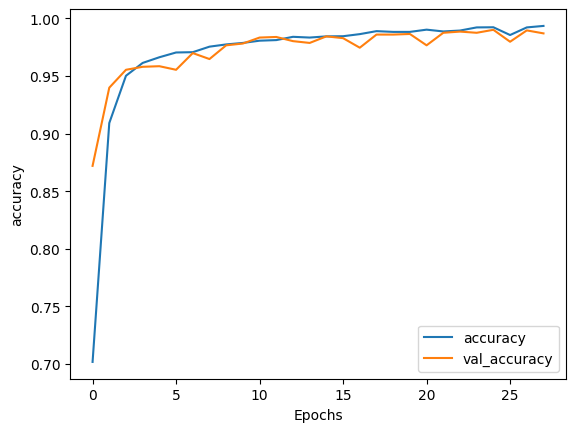

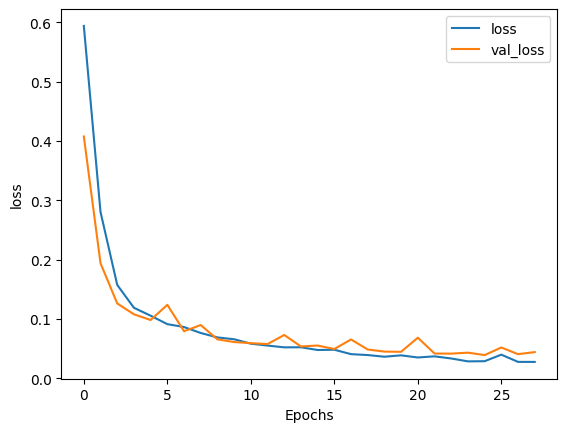

In [70]:
# plot graph of accuracy and loss over time
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [71]:
# save the model
model.save('spam_classifier.h5')

model.save('spam_classifier.keras')


In [72]:
loaded_model = tf.keras.models.load_model('spam_classifier.h5')
loaded_model.summary()
loaded_model.evaluate(testing_padded, y_test, verbose=2)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,435 (32.95 KB)

 Trainable params: 8,433 (32.94 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

61/61 - 0s - 7ms/step - accuracy: 0.9870 - loss: 0.0441


[0.044114258140325546, 0.9870466589927673]

## LSTM


In [73]:
# parameters
n_lstm = 128
drop = 0.2

In [74]:
# model architecture

model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model_lstm.add(SpatialDropout1D(drop))
model_lstm.add(LSTM(n_lstm, return_sequences=False))
model_lstm.add(Dropout(drop))
model_lstm.add(Dense(1, activation='sigmoid'))


model_lstm.build(input_shape=(None, max_len))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lstm.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ (None, 100, 16)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,369 (321.75 KB)

 Trainable params: 82,369 (321.75 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history_lstm = model_lstm.fit(training_padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test), callbacks=[early_stop], verbose=2)


Epoch 1/30
242/242 - 35s - 143ms/step - accuracy: 0.5052 - loss: 0.6935 - val_accuracy: 0.5104 - val_loss: 0.6930
Epoch 2/30
242/242 - 35s - 143ms/step - accuracy: 0.4925 - loss: 0.6935 - val_accuracy: 0.5104 - val_loss: 0.6930
Epoch 3/30
242/242 - 38s - 156ms/step - accuracy: 0.4983 - loss: 0.6934 - val_accuracy: 0.5104 - val_loss: 0.6931


In [76]:
model_lstm.evaluate(testing_padded, y_test)

61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.5163 - loss: 0.6930


[0.6930528283119202, 0.5103626847267151]

In [96]:
train_lstm_results = model_lstm.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_lstm_results = model_lstm.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)

print(f'Train accuracy: {train_lstm_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_lstm_results[1]*100:0.2f}')

31/31 - 12s - 387ms/step - accuracy: 0.4974 - loss: 0.6932
8/8 - 3s - 370ms/step - accuracy: 0.5104 - loss: 0.6931
Train accuracy: 49.74
Valid accuracy: 51.04


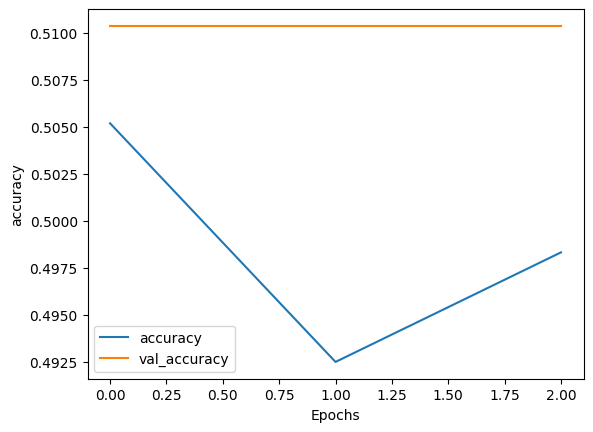

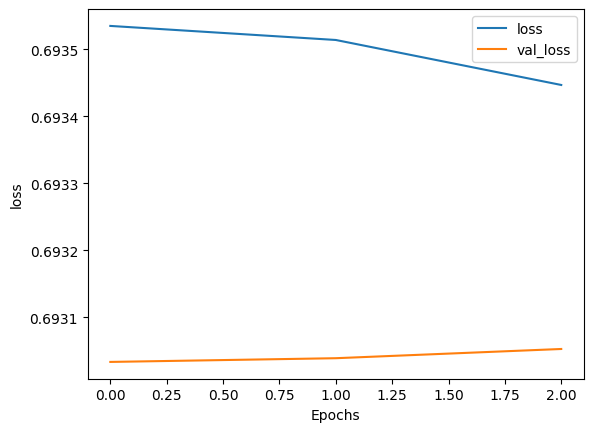

In [78]:
# plot graph of accuracy and loss over time
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

In [81]:
# save the model and weights
model_lstm.save('spam_classifier_lstm.h5')
model_lstm.save_weights('spam_classifier_lstm.weights.h5')

## BiLSTM

In [82]:
# parameters
n_bilstm = 128
drop = 0.2

In [84]:
# model architecture
model_bilstm = Sequential()
model_bilstm.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model_bilstm.add(SpatialDropout1D(drop))
model_bilstm.add(Bidirectional(LSTM(n_bilstm, return_sequences=False)))
model_bilstm.add(Dropout(drop))
model_bilstm.add(Dense(1, activation='sigmoid'))

model_bilstm.build(input_shape=(None, max_len))
model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_bilstm.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_4             │ (None, 100, 16)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       148,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,737 (612.25 KB)

 Trainable params: 156,737 (612.25 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history_bilstm = model_bilstm.fit(training_padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test), callbacks=[early_stop], verbose=2)

Epoch 1/30
242/242 - 48s - 197ms/step - accuracy: 0.8824 - loss: 0.2614 - val_accuracy: 0.9617 - val_loss: 0.1089
Epoch 2/30
242/242 - 41s - 169ms/step - accuracy: 0.9698 - loss: 0.0917 - val_accuracy: 0.9777 - val_loss: 0.0695
Epoch 3/30
242/242 - 37s - 154ms/step - accuracy: 0.9790 - loss: 0.0638 - val_accuracy: 0.9824 - val_loss: 0.0580
Epoch 4/30
242/242 - 37s - 154ms/step - accuracy: 0.9852 - loss: 0.0472 - val_accuracy: 0.9886 - val_loss: 0.0492
Epoch 5/30
242/242 - 38s - 155ms/step - accuracy: 0.9881 - loss: 0.0411 - val_accuracy: 0.9865 - val_loss: 0.0539
Epoch 6/30
242/242 - 35s - 146ms/step - accuracy: 0.9908 - loss: 0.0336 - val_accuracy: 0.9902 - val_loss: 0.0443
Epoch 7/30
242/242 - 39s - 162ms/step - accuracy: 0.9911 - loss: 0.0333 - val_accuracy: 0.9891 - val_loss: 0.0440
Epoch 8/30
242/242 - 40s - 166ms/step - accuracy: 0.9933 - loss: 0.0278 - val_accuracy: 0.9834 - val_loss: 0.0736
Epoch 9/30
242/242 - 42s - 174ms/step - accuracy: 0.9913 - loss: 0.0315 - val_accuracy: 

In [86]:
model_bilstm.evaluate(testing_padded, y_test)

61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9896 - loss: 0.0430


[0.04484599083662033, 0.9880828857421875]

In [87]:
training_bil_results = model_bilstm.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_bil_results = model_bilstm.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)

print(f'Train accuracy: {training_bil_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_bil_results[1]*100:0.2f}')

31/31 - 12s - 401ms/step - accuracy: 0.9942 - loss: 0.0244
8/8 - 2s - 306ms/step - accuracy: 0.9881 - loss: 0.0448
Train accuracy: 99.42
Valid accuracy: 98.81


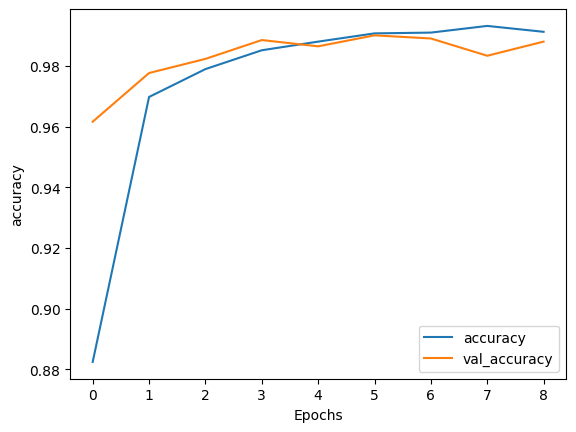

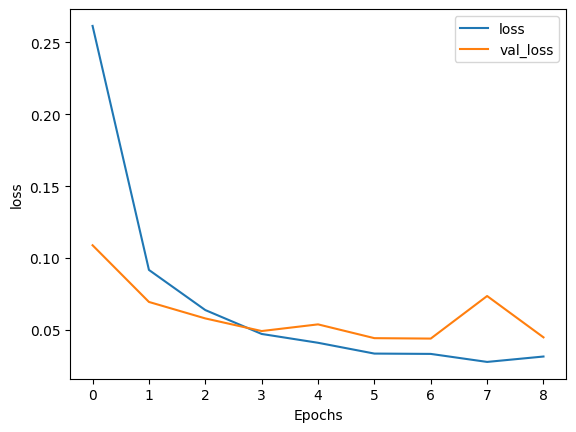

In [88]:
# plot graph of accuracy and loss over time
plot_graphs(history_bilstm, 'accuracy')
plot_graphs(history_bilstm, 'loss')

# save the model and weights
model_bilstm.save('spam_classifier_bilstm.h5')
model_bilstm.save_weights('spam_classifier_bilstm.weights.h5')

## GRU

In [89]:
model_gru = Sequential()
model_gru.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model_gru.add(SpatialDropout1D(drop))
model_gru.add(GRU(n_lstm, return_sequences=False))
model_gru.add(Dropout(drop))
model_gru.add(Dense(1, activation='sigmoid'))

model_gru.build(input_shape=(None, max_len))
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_gru.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_5             │ (None, 100, 16)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        56,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,193 (250.75 KB)

 Trainable params: 64,193 (250.75 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history_gru = model_gru.fit(training_padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test), callbacks=[early_stop], verbose=2)

Epoch 1/30
242/242 - 43s - 178ms/step - accuracy: 0.4944 - loss: 0.6937 - val_accuracy: 0.4896 - val_loss: 0.6933
Epoch 2/30
242/242 - 36s - 149ms/step - accuracy: 0.5017 - loss: 0.6935 - val_accuracy: 0.5104 - val_loss: 0.6929
Epoch 3/30
242/242 - 41s - 168ms/step - accuracy: 0.4934 - loss: 0.6936 - val_accuracy: 0.4896 - val_loss: 0.6932
Epoch 4/30
242/242 - 41s - 168ms/step - accuracy: 0.5017 - loss: 0.6933 - val_accuracy: 0.4896 - val_loss: 0.6934


In [91]:
model_gru.evaluate(testing_padded, y_test)

61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.4837 - loss: 0.6936


[0.6934438943862915, 0.4896373152732849]

In [92]:
training_gru_results = model_gru.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_gru_results = model_gru.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)

print(f'Train accuracy: {training_gru_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_gru_results[1]*100:0.2f}')

31/31 - 8s - 251ms/step - accuracy: 0.5026 - loss: 0.6932
8/8 - 2s - 266ms/step - accuracy: 0.4896 - loss: 0.6934
Train accuracy: 50.26
Valid accuracy: 48.96


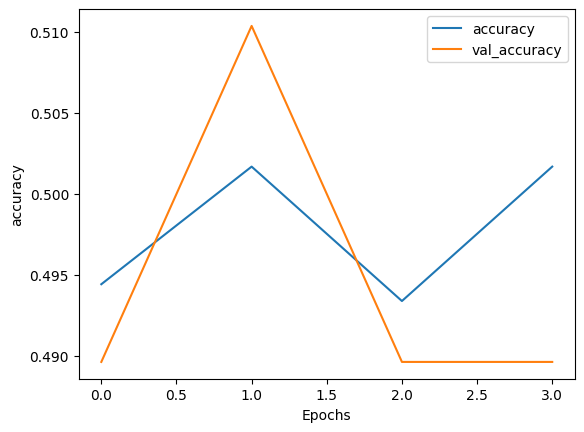

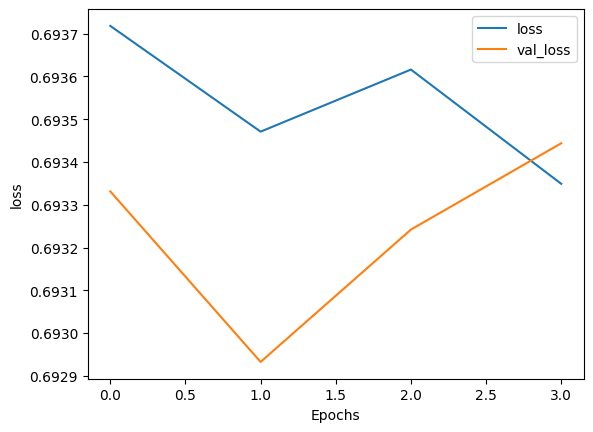

In [93]:
#plot graph of accuracy and loss over time
plot_graphs(history_gru, 'accuracy')
plot_graphs(history_gru, 'loss')

In [94]:
model_gru.save('spam_classifier_gru.h5')

## Comparision of Models


In [100]:
# tabulatw the results

results = pd.DataFrame({'Model': ['Dense', 'LSTM', 'BiLSTM', 'GRU'],
                        'Train Accuracy': [train_dense_results[1], train_lstm_results[1], training_bil_results[1], training_gru_results[1]],
                        'Valid Accuracy': [valid_dense_results[1], valid_lstm_results[1], valid_bil_results[1], valid_gru_results[1]]})

results

,Model,Train Accuracy,Valid Accuracy
0,Dense,0.994819,0.987047
1,LSTM,0.497409,0.510363
2,BiLSTM,0.994171,0.988083
3,GRU,0.502591,0.489637
